In [16]:
import numpy as np;
import torch 
from PIL import Image
import os 
from torchvision  import datasets, transforms
from torch.utils.data import DataLoader, random_split; 
import matplotlib.pyplot as plt
import torch.nn as nn; 
import torch.optim as optim; 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report


In [17]:
transform = transforms.Compose([
    
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(10), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) #* these  values i use for grayscale since the chest x rays is 
])



In [18]:
data_dir = './Datasets/LungXRays-grayscale'


In [19]:

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)
 
image, label = test_dataset[0]; 
print(image.shape)

torch.Size([3, 224, 224])


In [20]:
## making the datasets loading 

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True); 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataiter = iter(train_loader)

images, labels =next(dataiter)
print(torch.min(images), torch.max(images))



tensor(-1.) tensor(1.)


In [21]:
##plotting the dataset disribution 



In [22]:
class SimpleCNN(nn.Module): 
    def __init__(self, num_classes = 4):
        super(SimpleCNN, self).__init__()
        
        self.features = nn.Sequential(
            
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,  padding=1), 
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 28 * 28, 512), #* making  the flatten
            nn.ReLU(inplace=True), 
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True), 
            nn.Dropout(),
            nn.Linear(256, num_classes)
        )
        
        
    def forward(self, x): 
        x = self.features(x); 
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
        
    

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SimpleCNN().to(device) 
criterion = nn.CrossEntropyLoss();  
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epoch = 20

In [24]:
#* we need to train the module 

def train_model(model, train_loader, criterion, optimizer, device):
    
    
    
        #* we sting the model into train mode
    model.train(); 
    
    learning_loss = 0.0; 
    correct = 0; 
    total = 0; 
    
    for inputs, labels in train_loader: 
        
        inputs, labels = inputs.to(device), labels.to(device)
        #* starting with the gradient from  the intial point 0 
        optimizer.zero_grad()
        outputs = model(inputs); 
        loss = criterion(outputs, labels); 
        loss.backward();
        optimizer.step(); 
        learning_loss += loss.item(); 
        _, predict = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predict == labels).sum().item(); 
    
    learning_loss_result = learning_loss / total if total > 0 else 0
    train_acc = 100 * correct /total if total > 0 else 0
    return learning_loss_result, train_acc
                

In [25]:
### evaluation the model

def validation(model, val_loader, criterion, device ): 
    model.eval(); 
    running_loss = 0.0; 
    total = 0; 
    correct = 0; 
    
    with torch.no_grad(): 
        for inputs, labels in val_loader: 
            inputs, labels = inputs.to(device), labels.to(device); 
            outputs = model(inputs); 
            loss = criterion(outputs, labels); 
            running_loss += loss.item(); 
            _,predict = torch.max(outputs, 1); 
            
            total  += labels.size(0); 
            correct  += (predict == labels).sum().item()
            
    result_running_loss = running_loss / total if total > 0 else 0 
    result_val_acc = 100* correct / total if total > 0 else 0; 
    return  result_running_loss, result_val_acc; 

In [ ]:
#* making class for early stopping 

from typing import Any


class EarlyStopping:
    def __init__(self, patience=5, verbose = False, delta = 0,  path= 'best.pt' ):
        
        self.patience = patience
        self.verbose = verbose 
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta
        self.path = path 
        
    def __call__(self, val_loss, model):
        
        if  self.best_loss is None or val_loss < self.best_loss - self.delta:
            
            if self.verbose:
                #* tracking  validation if decreases 
                print(f"Validation loss decreased from {self.best_loss:.4f} to {val_loss:.4f}. Saving model. ")
            self.best_loss  = val_loss
            self.Save_best_model(model)
            self.counter = 0
            
        else: 
            self.counter += 1 
            
            if self.verbose: 
                print(f'Early stopping Counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        
    
    def Save_best_model(self, model): 
        torch.save(model.state_dict(), self.path)
                
   
        

In [ ]:
earlyStopping = EarlyStopping(patience=5, verbose=True, path='best_simpleCNN.pth')

train_losses, train_accs, val_losses, val_accs =[], [], [], []
for epoch in range(num_epoch):
    
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validation(model, val_loader, criterion, device)
    train_losses.append(train_loss); 
    train_accs.append(train_acc); 
    val_losses.append(val_loss)
    val_accs.append(val_acc); 

    print(f'Epoch {epoch+1}/{num_epoch}: Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    earlyStopping(val_loss, model)
    if earlyStopping.early_stop: 
        print('Note early stopping is triggered no need more training')
        break
    

Epoch 1/10: Train Loss: 0.0275 Train Acc: 62.4151, Val Loss: 0.0173, Val Acc: 79.2593
Epoch 2/10: Train Loss: 0.0169 Train Acc: 79.3047, Val Loss: 0.0131, Val Acc: 84.4444
Epoch 3/10: Train Loss: 0.0134 Train Acc: 83.5836, Val Loss: 0.0118, Val Acc: 86.9136
Epoch 4/10: Train Loss: 0.0120 Train Acc: 86.0523, Val Loss: 0.0114, Val Acc: 87.4074
Epoch 5/10: Train Loss: 0.0108 Train Acc: 87.0397, Val Loss: 0.0094, Val Acc: 89.8765
Epoch 6/10: Train Loss: 0.0101 Train Acc: 88.4592, Val Loss: 0.0106, Val Acc: 87.9012
Epoch 7/10: Train Loss: 0.0089 Train Acc: 89.3849, Val Loss: 0.0093, Val Acc: 89.9383
Epoch 8/10: Train Loss: 0.0087 Train Acc: 89.9815, Val Loss: 0.0093, Val Acc: 89.9383
Epoch 9/10: Train Loss: 0.0086 Train Acc: 89.7552, Val Loss: 0.0082, Val Acc: 90.9877
Epoch 10/10: Train Loss: 0.0079 Train Acc: 90.4341, Val Loss: 0.0087, Val Acc: 90.3086


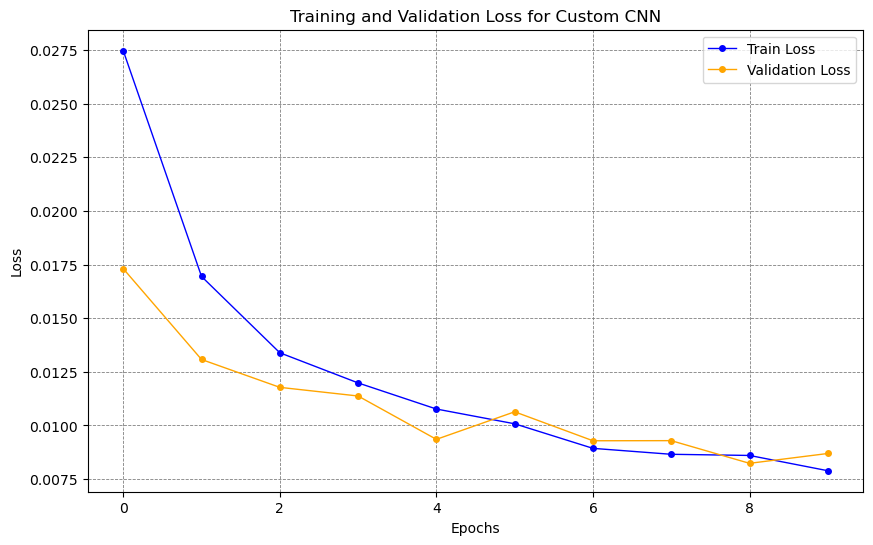

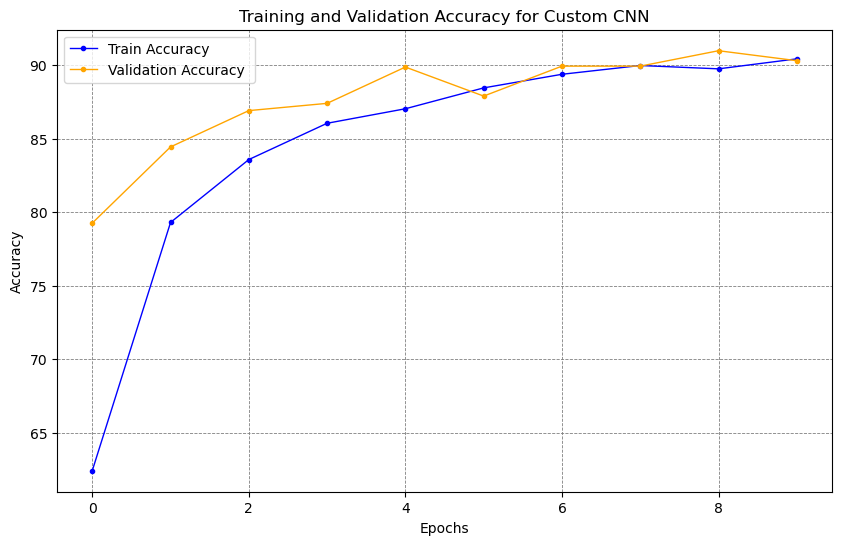

In [27]:
def Plot_metrics(train_losses, val_losses, train_accs, val_accs):
    #* range for the plot 
    epoch = list(range(0, num_epoch))
    plt.figure(figsize=(10, 6))
    plt.plot(epoch, train_losses, label= 'Train Loss', color = 'blue',  marker='o', markersize=4, linestyle='-', linewidth=1)
    plt.plot(epoch, val_losses, label='Validation Loss', color='orange',  marker='o', markersize=4, linestyle='-', linewidth=1)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss for Custom CNN')
    plt.grid(True, which='both', linestyle='--', linewidth=0.6, color='gray')
    plt.show()
    
    
    epoch = list(range(0, num_epoch))
    plt.figure(figsize=(10, 6))
    plt.plot(epoch, train_accs, label= 'Train Accuracy ', color = 'blue',  marker='o', markersize=3, linestyle='-', linewidth=1)
    plt.plot(epoch, val_accs, label='Validation Accuracy ', color='orange',  marker='o', markersize=3, linestyle='-', linewidth=1)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy for Custom CNN')
    plt.grid(True, which='both', linestyle='--', linewidth=0.6, color='gray')
    plt.show()



Plot_metrics(train_losses, val_losses, train_accs, val_accs)
    

In [28]:
#*  Model evaluation 
def evaluation (model, test_loader,  criterion, device ):
    test_loss = 0.0;
    all_pred, all_labels = [], []
    correct = 0;
    total = 0; 
    model.eval();  
    with torch.no_grad(): 
        
        for inputs, labels in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device); 
            outputs = model(inputs); 
            loss = criterion(outputs, labels); 
            test_loss += loss.item(); 
            _, predict = torch.max(outputs, 1); 
            total += labels.size(0); 
            correct += (predict==labels).sum().item()
            all_pred.extend(predict.cpu().numpy())
            all_labels.extend(labels.cpu().numpy());
            
            
            result_test_loss = test_loss / len(test_loader); 
            result_test_acc = 100 * correct / total; 
    return result_test_loss, result_test_acc, all_pred, all_labels; 
          




In [29]:
test_loss, test_acc, all_preds, all_labels = evaluation(model, test_loader, criterion, device)
print(f'Test Accuaracy: {test_acc:.4f}')

Test Accuaracy: 92.2462


Accuracy: 0.9225

 classification Report
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       378
           1       0.94      0.90      0.92       419
           2       0.91      0.91      0.91       406
           3       0.96      0.93      0.95       422

    accuracy                           0.92      1625
   macro avg       0.92      0.92      0.92      1625
weighted avg       0.92      0.92      0.92      1625



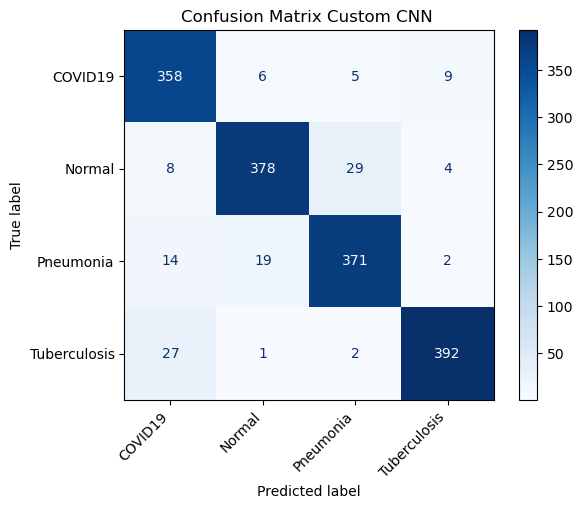

In [30]:
## Confusion metrics 
accuracy = accuracy_score(all_preds, all_labels)
print(f"Accuracy: {accuracy:.4f}")
print('\n classification Report')
cls_report = classification_report(all_preds, all_labels)
print(cls_report)

cm = confusion_matrix(all_preds, all_labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
display.plot(cmap='Blues')
plt.xticks(rotation = 45, ha= 'right')
plt.title('Confusion Matrix Custom CNN ')
plt.show()

In [31]:
## testing the models predicts if the classifier